# Assignment 6 <br/>


In [63]:
from dwave.system.samplers import DWaveSampler
from dimod.reference.samplers import ExactSolver
from dwave.cloud import Client
from dwave.system.composites import EmbeddingComposite
import dwavebinarycsp as csp
import networkx as nx
import dwave_networkx as dnx
import matplotlib.pyplot as plt    
from dimod.generators import combinations
from dimod import BinaryQuadraticModel
import dwave.inspector

TestCPU = ExactSolver()

client = Client.from_config()
client.get_solvers()



[BQMSolver(id='hybrid_binary_quadratic_model_version2'),
 DQMSolver(id='hybrid_discrete_quadratic_model_version1'),
 StructuredSolver(id='Advantage_system4.1'),
 CQMSolver(id='hybrid_constrained_quadratic_model_version1'),
 StructuredSolver(id='Advantage_system6.1'),
 StructuredSolver(id='Advantage2_prototype1.1'),
 StructuredSolver(id='DW_2000Q_6')]

In [25]:
sampler_2000 = DWaveSampler(id='DW_2000Q_6')
sampler_Adv = DWaveSampler(id = 'Advantage_system4.1')

**Question 1** <br/>
Given the solution to every possible 3-SAT must have one of the parameters equal to binary 1 and the other parameters equal to 0 and that the QUBO generated to represent this 3-SAT assumes that two qubits must be the same in value and will together represent one parameter of the 3-SAT (q0 = q5). This defines the equation of the QUBO to be: <br/>
<div align = "center"> E(q) = (1/3)(q0 + q5) - (1/3)(q1 + q4) + (2/3)(q0q4 + q1q4 + q1q5) - (q0q5) <br/><br/> </div>
The QUBO representation is given by the following code (as was defined in class). For this code q0 = q30, q1 = q46, q4 = q31, and q5 = q45.

In [28]:
q_biases = {(30, 30): 0.33, (46, 46): -0.33, (31, 31): -0.33, (45, 45): 0.33}
c_strength = {(30, 31): 0.66, (46, 31): 0.66, (46, 45): 0.66, (30, 45): -1}
Q1 = dict(q_biases)
Q1.update(c_strength)

r = sampler_2000.sample_qubo(Q1, num_reads=1000)
for (sample, energy, num) in r.data():
    print(sample, "Energy: ", energy, "Occurrences: ", num)

{30: 1, 31: 0, 45: 1, 46: 0} Energy:  -0.33999999999999997 Occurrences:  256
{30: 0, 31: 0, 45: 0, 46: 1} Energy:  -0.33000000000000007 Occurrences:  289
{30: 0, 31: 1, 45: 0, 46: 0} Energy:  -0.32999999999999996 Occurrences:  448
{30: 1, 31: 0, 45: 1, 46: 1} Energy:  -0.009999999999999981 Occurrences:  1
{30: 1, 31: 1, 45: 1, 46: 0} Energy:  -0.009999999999999981 Occurrences:  3
{30: 0, 31: 1, 45: 0, 46: 1} Energy:  -2.7755575615628914e-17 Occurrences:  1
{30: 0, 31: 0, 45: 0, 46: 0} Energy:  0.0 Occurrences:  2


By comparing these results to results gathered from a "brute force" solution, we can confirm that the QUBO does in fact compute the proper minimization solutions of the 3-SAT problem.

In [12]:
rCPU = TestCPU.sample_qubo(Q1)
for(sample, energy, num) in rCPU.data():
    print(sample, "Energy:", energy, "Number:", num)

{30: 1, 31: 0, 45: 1, 46: 0} Energy: -0.33999999999999997 Number: 1
{30: 0, 31: 0, 45: 0, 46: 1} Energy: -0.33 Number: 1
{30: 0, 31: 1, 45: 0, 46: 0} Energy: -0.33 Number: 1
{30: 1, 31: 1, 45: 1, 46: 0} Energy: -0.010000000000000009 Number: 1
{30: 1, 31: 0, 45: 1, 46: 1} Energy: -0.009999999999999898 Number: 1
{30: 0, 31: 0, 45: 0, 46: 0} Energy: 0.0 Number: 1
{30: 1, 31: 0, 45: 0, 46: 1} Energy: 0.0 Number: 1
{30: 0, 31: 1, 45: 0, 46: 1} Energy: 0.0 Number: 1
{30: 0, 31: 1, 45: 1, 46: 0} Energy: 0.0 Number: 1
{30: 1, 31: 0, 45: 0, 46: 0} Energy: 0.33 Number: 1
{30: 0, 31: 0, 45: 1, 46: 0} Energy: 0.33 Number: 1
{30: 1, 31: 1, 45: 0, 46: 0} Energy: 0.66 Number: 1
{30: 0, 31: 0, 45: 1, 46: 1} Energy: 0.66 Number: 1
{30: 1, 31: 1, 45: 1, 46: 1} Energy: 0.9800000000000001 Number: 1
{30: 1, 31: 1, 45: 0, 46: 1} Energy: 0.99 Number: 1
{30: 0, 31: 1, 45: 1, 46: 1} Energy: 0.99 Number: 1


These results outline that the lowest energy state occurs in one of three states (noting the qubit naming replacements listed above): (q0 = 1,q1 = 0, q4 = 0, q5 = 1), (q0 = 0, q1 = 1, q4 = 0, q5 = 0), and (q0 = 0, q1 = 0, q4 = 1, q5 = 0). These results line up with the results of the quantum computations done in the previous code section as the same states are identified as the minimums in the majority of the readings. Additionally, these results are consistent with 3-SAT problems as each of the solutions has one of the parameters set to 1 and the other two parameters set to 0 (noting that q0 and q5 are together set as one parameter).

**Question 2** <br/>
The 3-SAT can be encoded into the system using the combination function to define the Binary Quadratic Model through the follwoing code.


In [18]:
#Set up the variables to be used
bits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

#define the bqm
bqm_clause = BinaryQuadraticModel('BINARY')
for i in range(8):
    each = [bits[i], bits[i + 1], bits[i + 2]]
    bqm_clause.update(combinations(each, 1))

print(bqm_clause)


BinaryQuadraticModel({'0': -1.0, '1': -2.0, '2': -3.0, '3': -3.0, '4': -3.0, '5': -3.0, '6': -3.0, '7': -3.0, '8': -2.0, '9': -1.0}, {('1', '0'): 2.0, ('2', '0'): 2.0, ('2', '1'): 4.0, ('3', '1'): 2.0, ('3', '2'): 4.0, ('4', '2'): 2.0, ('4', '3'): 4.0, ('5', '3'): 2.0, ('5', '4'): 4.0, ('6', '4'): 2.0, ('6', '5'): 4.0, ('7', '5'): 2.0, ('7', '6'): 4.0, ('8', '6'): 2.0, ('8', '7'): 4.0, ('9', '7'): 2.0, ('9', '8'): 2.0}, 8.0, 'BINARY')


This BQM can be run with the ExactSolver to get a full list of all possible answers as shown below.

In [27]:
rCPU2 = TestCPU.sample(bqm_clause)
for(sample, energy, num) in rCPU2.data():
    print(sample, "Energy:", energy, "Number:", num)

{'0': 0, '1': 1, '2': 0, '3': 0, '4': 1, '5': 0, '6': 0, '7': 1, '8': 0, '9': 0} Energy: 0.0 Number: 1
{'0': 0, '1': 0, '2': 1, '3': 0, '4': 0, '5': 1, '6': 0, '7': 0, '8': 1, '9': 0} Energy: 0.0 Number: 1
{'0': 1, '1': 0, '2': 0, '3': 1, '4': 0, '5': 0, '6': 1, '7': 0, '8': 0, '9': 1} Energy: 0.0 Number: 1
{'0': 0, '1': 1, '2': 0, '3': 0, '4': 1, '5': 0, '6': 0, '7': 0, '8': 1, '9': 0} Energy: 1.0 Number: 1
{'0': 0, '1': 1, '2': 0, '3': 1, '4': 0, '5': 0, '6': 1, '7': 0, '8': 0, '9': 1} Energy: 1.0 Number: 1
{'0': 1, '1': 0, '2': 0, '3': 1, '4': 0, '5': 0, '6': 1, '7': 0, '8': 0, '9': 0} Energy: 1.0 Number: 1
{'0': 1, '1': 0, '2': 0, '3': 1, '4': 0, '5': 0, '6': 1, '7': 0, '8': 1, '9': 0} Energy: 1.0 Number: 1
{'0': 0, '1': 0, '2': 0, '3': 1, '4': 0, '5': 0, '6': 1, '7': 0, '8': 0, '9': 1} Energy: 1.0 Number: 1
{'0': 0, '1': 0, '2': 1, '3': 0, '4': 0, '5': 1, '6': 0, '7': 0, '8': 0, '9': 1} Energy: 1.0 Number: 1
{'0': 0, '1': 0, '2': 1, '3': 0, '4': 0, '5': 1, '6': 0, '7': 0, '8': 1, 

Additionally, this code can be run on a quantum computer (using DW_2000Q_6) to compare with the identified solutions of the brute force calculations.

In [43]:
sampler2_2000 = EmbeddingComposite(DWaveSampler(id='DW_2000Q_6'))
rQC2 = sampler2_2000.sample(bqm_clause, num_reads = 1000)
print(rQC2)

    0  1  2  3  4  5  6  7  8  9 energy num_oc. chain_.
0   0  0  1  0  0  1  0  0  1  0    0.0     364     0.0
1   0  1  0  0  1  0  0  1  0  0    0.0     264     0.0
2   1  0  0  1  0  0  1  0  0  1    0.0     239     0.0
3   0  0  1  0  0  0  1  0  0  1    1.0       5     0.0
4   0  1  0  1  0  0  1  0  0  1    1.0       6     0.0
5   1  1  0  0  1  0  0  1  0  0    1.0       6     0.0
6   0  1  0  0  1  0  1  0  0  1    1.0       7     0.0
7   0  1  0  0  1  0  0  1  0  1    1.0       2     0.0
8   1  0  0  0  1  0  0  1  0  0    1.0       5     0.0
9   0  0  1  0  1  0  0  1  0  0    1.0      14     0.0
10  0  1  0  0  1  0  0  0  1  0    1.0      16     0.0
11  0  0  1  0  0  1  0  1  0  0    1.0       7     0.0
12  0  0  1  0  0  1  0  0  0  1    1.0       3     0.0
13  1  0  1  0  0  1  0  0  1  0    1.0       5     0.0
14  1  0  0  1  0  0  0  1  0  0    1.0       6     0.0
15  0  0  1  0  0  1  0  0  1  1    1.0      10     0.0
16  1  0  0  1  0  0  1  0  0  0    1.0       1 

This section shows the same three samples as the correct qubit selection to maximize the amount of true clauses. These selections align with the clauses identified by the ExactSolver as having the minimum energy. The three correct solutions are displayed below.

In [54]:
best2 = rQC2.lowest()
print("The three optimized solutions are:")
for sample in best2:
    print(sample)


The three optimized solutions are:
{'0': 0, '1': 0, '2': 1, '3': 0, '4': 0, '5': 1, '6': 0, '7': 0, '8': 1, '9': 0}
{'0': 0, '1': 1, '2': 0, '3': 0, '4': 1, '5': 0, '6': 0, '7': 1, '8': 0, '9': 0}
{'0': 1, '1': 0, '2': 0, '3': 1, '4': 0, '5': 0, '6': 1, '7': 0, '8': 0, '9': 1}


**Question 3** <br/>
For this question, we can generate the shape as defined before solving the minimum vertex cover problem using a QPU and comaring the answers against the minimum value detemined using the ExactSolver.

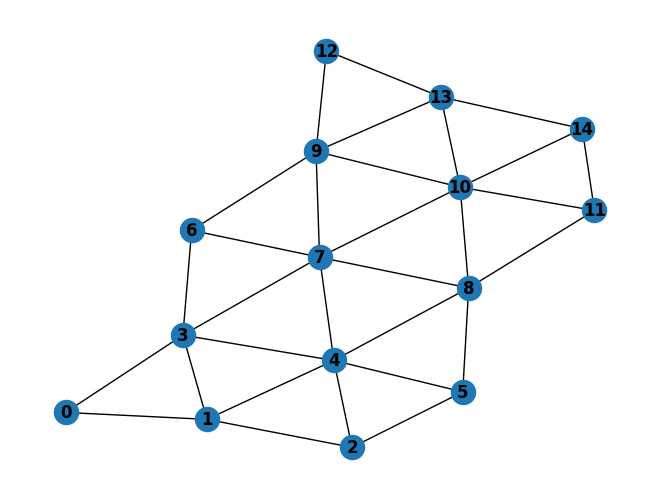

In [62]:
G=nx.triangular_lattice_graph(4, 4)
G=nx.convert_node_labels_to_integers(G)
nx.draw(G, with_labels=True, font_weight= 'bold')
plt.savefig('graph_A6.pdf')

In [64]:
sol = dnx.min_vertex_cover(G, sampler2_2000)
print(sol)

[1, 3, 4, 5, 7, 9, 10, 11, 13]


The answer above was determined to be the minimum vertex cover as calculated by the QPU. This is verified by manually computing the minimum using the ExactSolver.

In [65]:
sol2 = dnx.min_vertex_cover(G, TestCPU)
print(sol2)

[1, 3, 4, 5, 7, 9, 10, 11, 13]


As can be seen above, the QPU and CPU both identified the same solution to the minimum vertex cover problem. The identified solution was to cover 9 points: 1, 3, 4, 5, 7, 9, 10, 11, and 13.

**Question 4** <br/>
This question can be approached similarly to a map colouring problem. For this, the shapes to be coloured, bordering shapes, and colours permitted are defined. Then, a "penalty" is defined for all shapes bordering on a shape of the same color and implemented into a bqm. This bqm is then sampled, which will define a colouring scheme which minimizes the bqm. A graph can be generated to show visually that two shapes of the same colour never share a border or the minimized energy of the bqm can be inspected to see if any penalties were encurred in the ideal solution (from noting if the minized energy is greater than 0).

In [87]:
#start by defining the parameters
nodes = nx.nodes(G)
borders = nx.edges(G)
colours = ['r', 'y', 'b']

#set variables for each node
bqm_colorset = BinaryQuadraticModel('BINARY')
for node in nodes:
    var = [str(node) + '_' + c for c in colours]
    bqm_colorset.update(combinations(var,1))

#create penalty for bordering colors being the same
bqm_borders = BinaryQuadraticModel('BINARY')
for border in borders:
    v, u = border
    interact = [(str(v) + '_' + c, str(u) + '_' + c) for c in colours]
    for i in interact:
        bqm_borders.add_quadratic(i[0], i[1], 1)

#create final bqm
bqm4 = bqm_borders + bqm_colorset

#evaluate on a QPU
sol3 = sampler2_2000.sample(bqm4, num_reads = 1000)
best4 = sol3.lowest()


The energies of the solution can then be checked to see if any penalties had occured. If the lowest energy was greater than 0 then a penalty has occured.

In [88]:
if best4.first.energy > 0:
    print('This graph cannot be coloured using only three colours')
else:
    print('This graph can be coloured using only three colours')

This graph can be coloured using only three colours


This has proved that the graph can be coloured using three colours with no adjacent shapes sharing a colour, but one possible solution (best4.first) can then be graphed to confirm this is feasible. The following code graphs the solution.

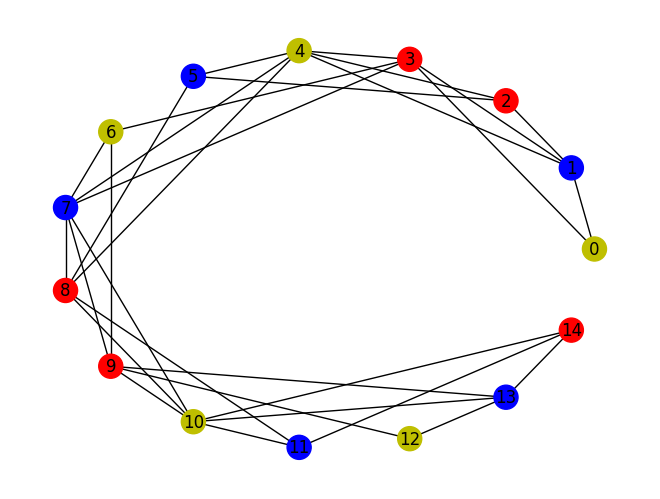

In [95]:
    P = nx.Graph()
    P.add_nodes_from(nodes)
    P.add_edges_from(borders)
    color_map = {}
    for node in nodes:
      for c in colours:
       if best4.first[0][str(node) + '_' + c]:
           color_map[node] = c
    # Plot with the selected colors
    node_colors = [color_map.get(node) for node in P.nodes()]
    nx.draw_circular(P, with_labels=True, node_color=node_colors, node_size=300, cmap=plt.cm.rainbow)
    plt.show()

As no nodes of the same colour are connected, this graph further confirms that only three colours are needed to colour this graph with no adjacent nodes being the same colour.